# Visualizing the network in nocebo research

https://towardsdatascience.com/network-analysis-to-quickly-get-insight-into-an-academic-field-with-python-cd891717d547
This is a pretty cool blogpost and I want to replicate it for my colleagues' field.

In [1]:
from Bio import Entrez, Medline
from tqdm import tqdm
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
import networkx as nx
from nxviz.plots import CircosPlot

In [2]:
#apparently only needed for telling me if I demand too much from the server. We'll see about that. 
Entrez.email = "l.neugebauer@uke.de";

#this is the topic we're looking for
keyword = 'nocebo';

#searching pubmed for this keyword
result = Entrez.read(Entrez.esearch(db="pubmed", retmax=10, term=keyword));
print("Total number of publications that contain the term {}: {}".format(keyword, result["Count"]));
# so far so good
# get the ids, could have done that before, but having an idea about the number of results is probably more efficient
MAX_COUNT = result["Count"]
result = Entrez.read( Entrez.esearch(db="pubmed", retmax=result["Count"], term=keyword));

Total number of publications that contain the term nocebo: 595


In [3]:
#download the abstracts in batches of 100
ids = result["IdList"]
batch_size = 100
batches = [ids[x: x + 100] for x in range(0, len(ids), batch_size)]
record_list = []
for batch in tqdm(batches):
    h = Entrez.efetch(db="pubmed", id=batch, rettype="medline", retmode="text")
    records = Medline.parse(h)
    record_list.extend(list(records))
print("Complete.")

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  1.99s/it]


Complete.


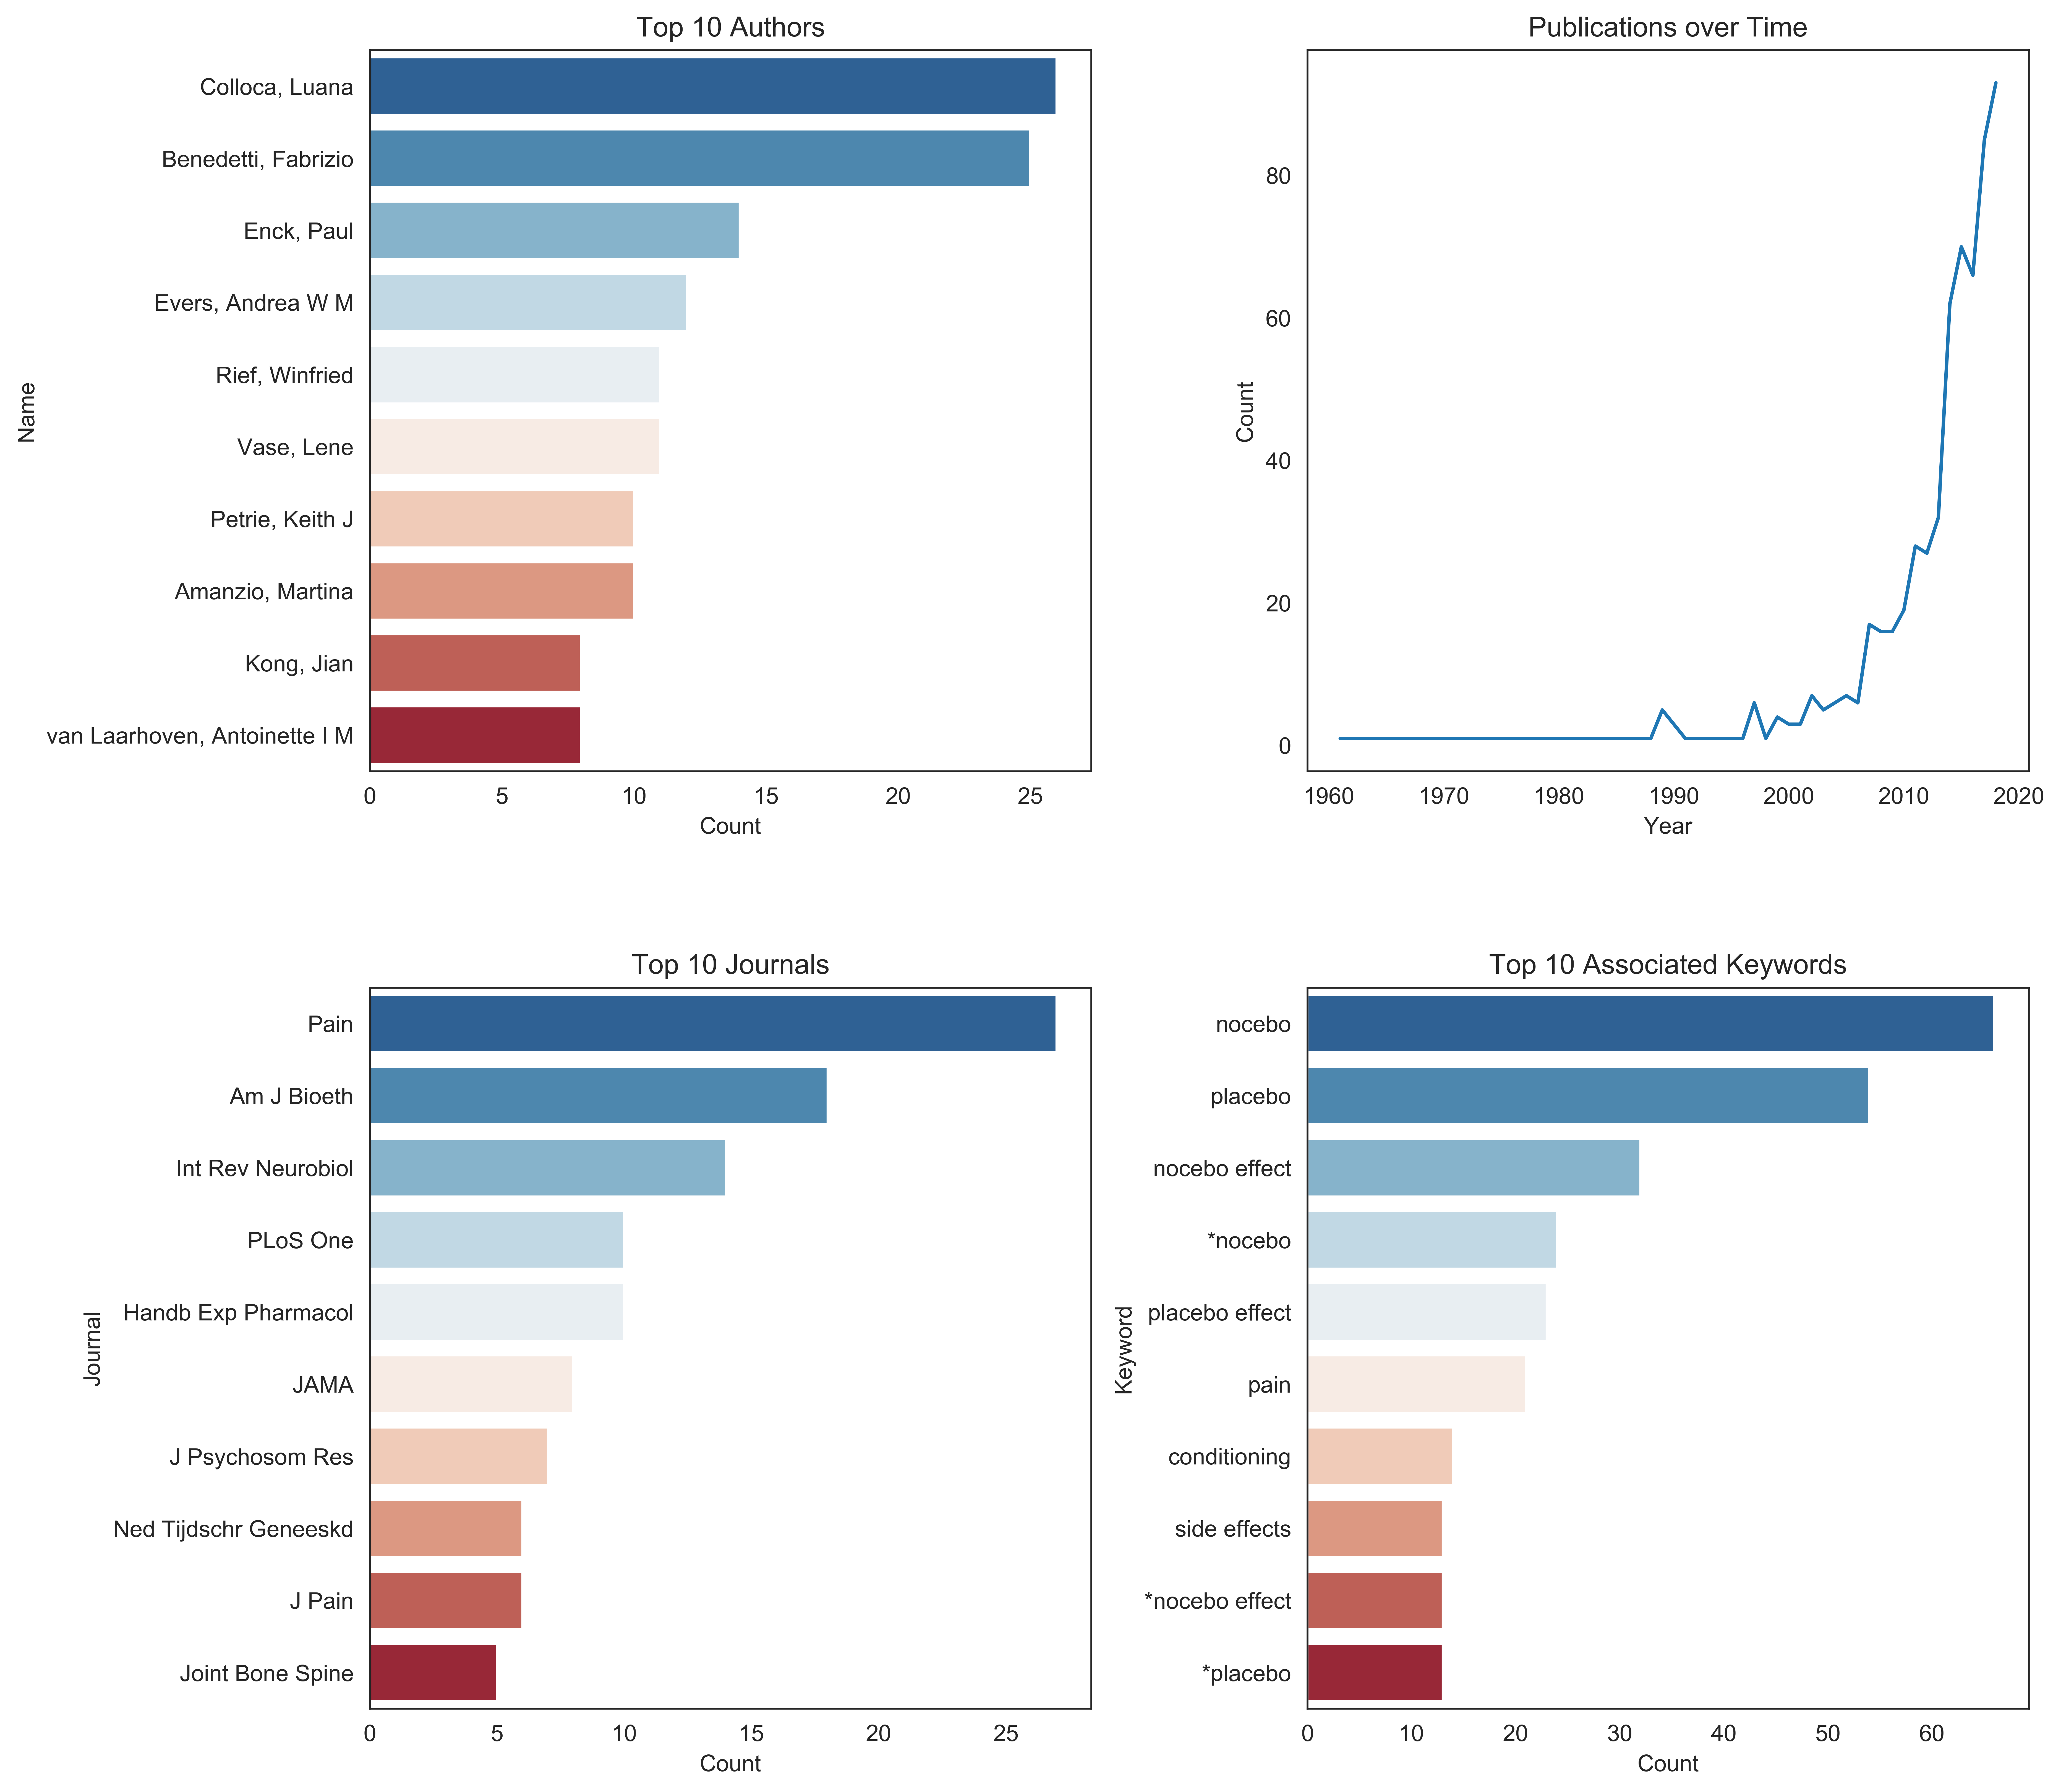

In [4]:
sns.set_style("white")
#make it a data frame
publication_data = pd.DataFrame(record_list)
#format year
publication_data["Year"] = (
    publication_data["EDAT"].astype(str).str[0:4].astype(int)
)
#open figure
plt.figure(figsize=(10,10), dpi=600)

#add top 10 authors
plt.subplot(2, 2, 1)
authors_flat = [ author for authors in list(publication_data["FAU"].dropna())  for author in authors ]
top10authors = pd.DataFrame.from_records(Counter(authors_flat).most_common(10), columns=["Name", "Count"])
sns.barplot(x="Count", y="Name", data=top10authors, palette="RdBu_r")
plt.title("Top 10 Authors")

# Publications over Time
plt.subplot(2, 2, 2)
yearly = pd.DataFrame(publication_data["Year"].value_counts().reset_index())
yearly.columns = ["Year", "Count"]
sns.lineplot(x="Year", y="Count", data=yearly)
plt.title("Publications over Time")

# TOP 10 Journals
plt.subplot(2, 2, 3)
top10journals = pd.DataFrame.from_records( Counter(publication_data["TA"]).most_common(10), columns=["Journal", "Count"],)
sns.barplot(x="Count", y="Journal", data=top10journals, palette="RdBu_r")
plt.title("Top 10 Journals")

# Top associated keywords
plt.subplot(2, 2, 4)

flat_kw = [_.lower() for kws in list(publication_data["OT"].dropna()) for _ in kws];# for _ in kw.split(" ")]

top10kw = pd.DataFrame.from_records(Counter(flat_kw).most_common(10), columns=["Keyword", "Count"])

sns.barplot(x="Count", y="Keyword", data=top10kw, palette="RdBu_r")
plt.title("Top 10 Associated Keywords")
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.3, wspace=0.3)
plt.show()

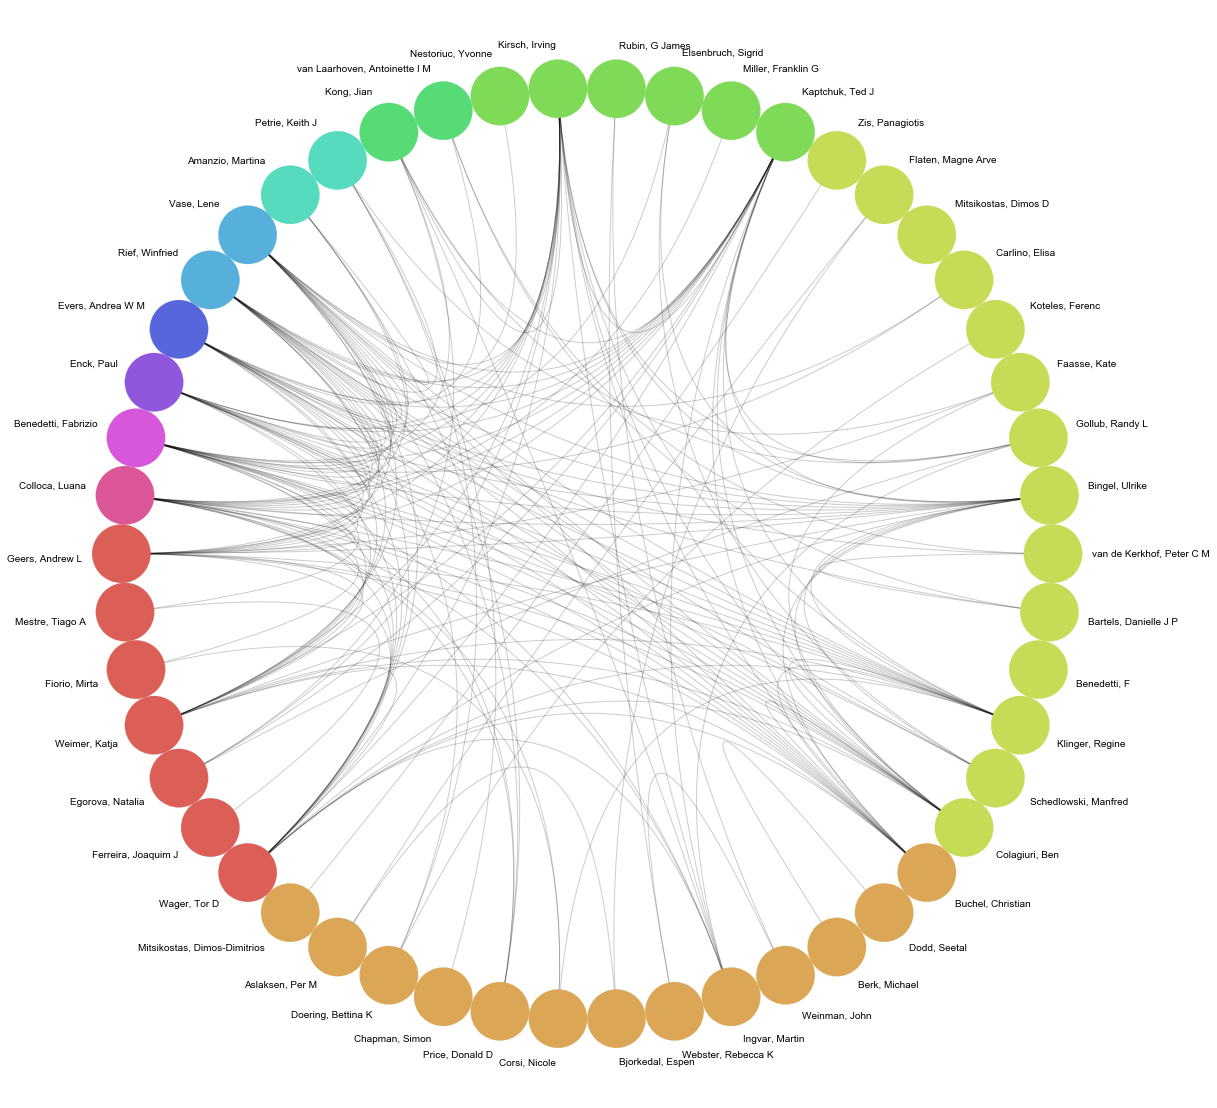

In [5]:
# Extract author connections
authors = publication_data["FAU"].dropna()
author_connections = list(map(lambda x: list(combinations(x[::-1], 2)), authors))
flat_connections = [item for sublist in author_connections for item in sublist]

# Create a dataframe with the connections
df = pd.DataFrame(flat_connections, columns=["From", "To"])
df_graph = df.groupby(["From", "To"]).size().reset_index()
df_graph.columns = ["From", "To", "Count"]


G = nx.from_pandas_edgelist( df_graph, source="From", target="To", edge_attr="Count")

# Limit to TOP 50 authors
top50authors = pd.DataFrame.from_records(
    Counter(authors_flat).most_common(50), columns=["Name", "Count"]
)

top50_nodes = (n for n in list(G.nodes()) if n in list(top50authors["Name"]))

G_50 = G.subgraph(top50_nodes)

for n in G_50.nodes(): 
    G_50.node[n]["publications"] = int( top50authors[top50authors["Name"] == n]["Count"] )

c = CircosPlot(
    G_50,
    dpi=600,
    node_grouping="publications",
    edge_width="Count",
    figsize=(20, 20),
    node_color="publications",
    node_labels=True,
)
c.draw()
plt.show()

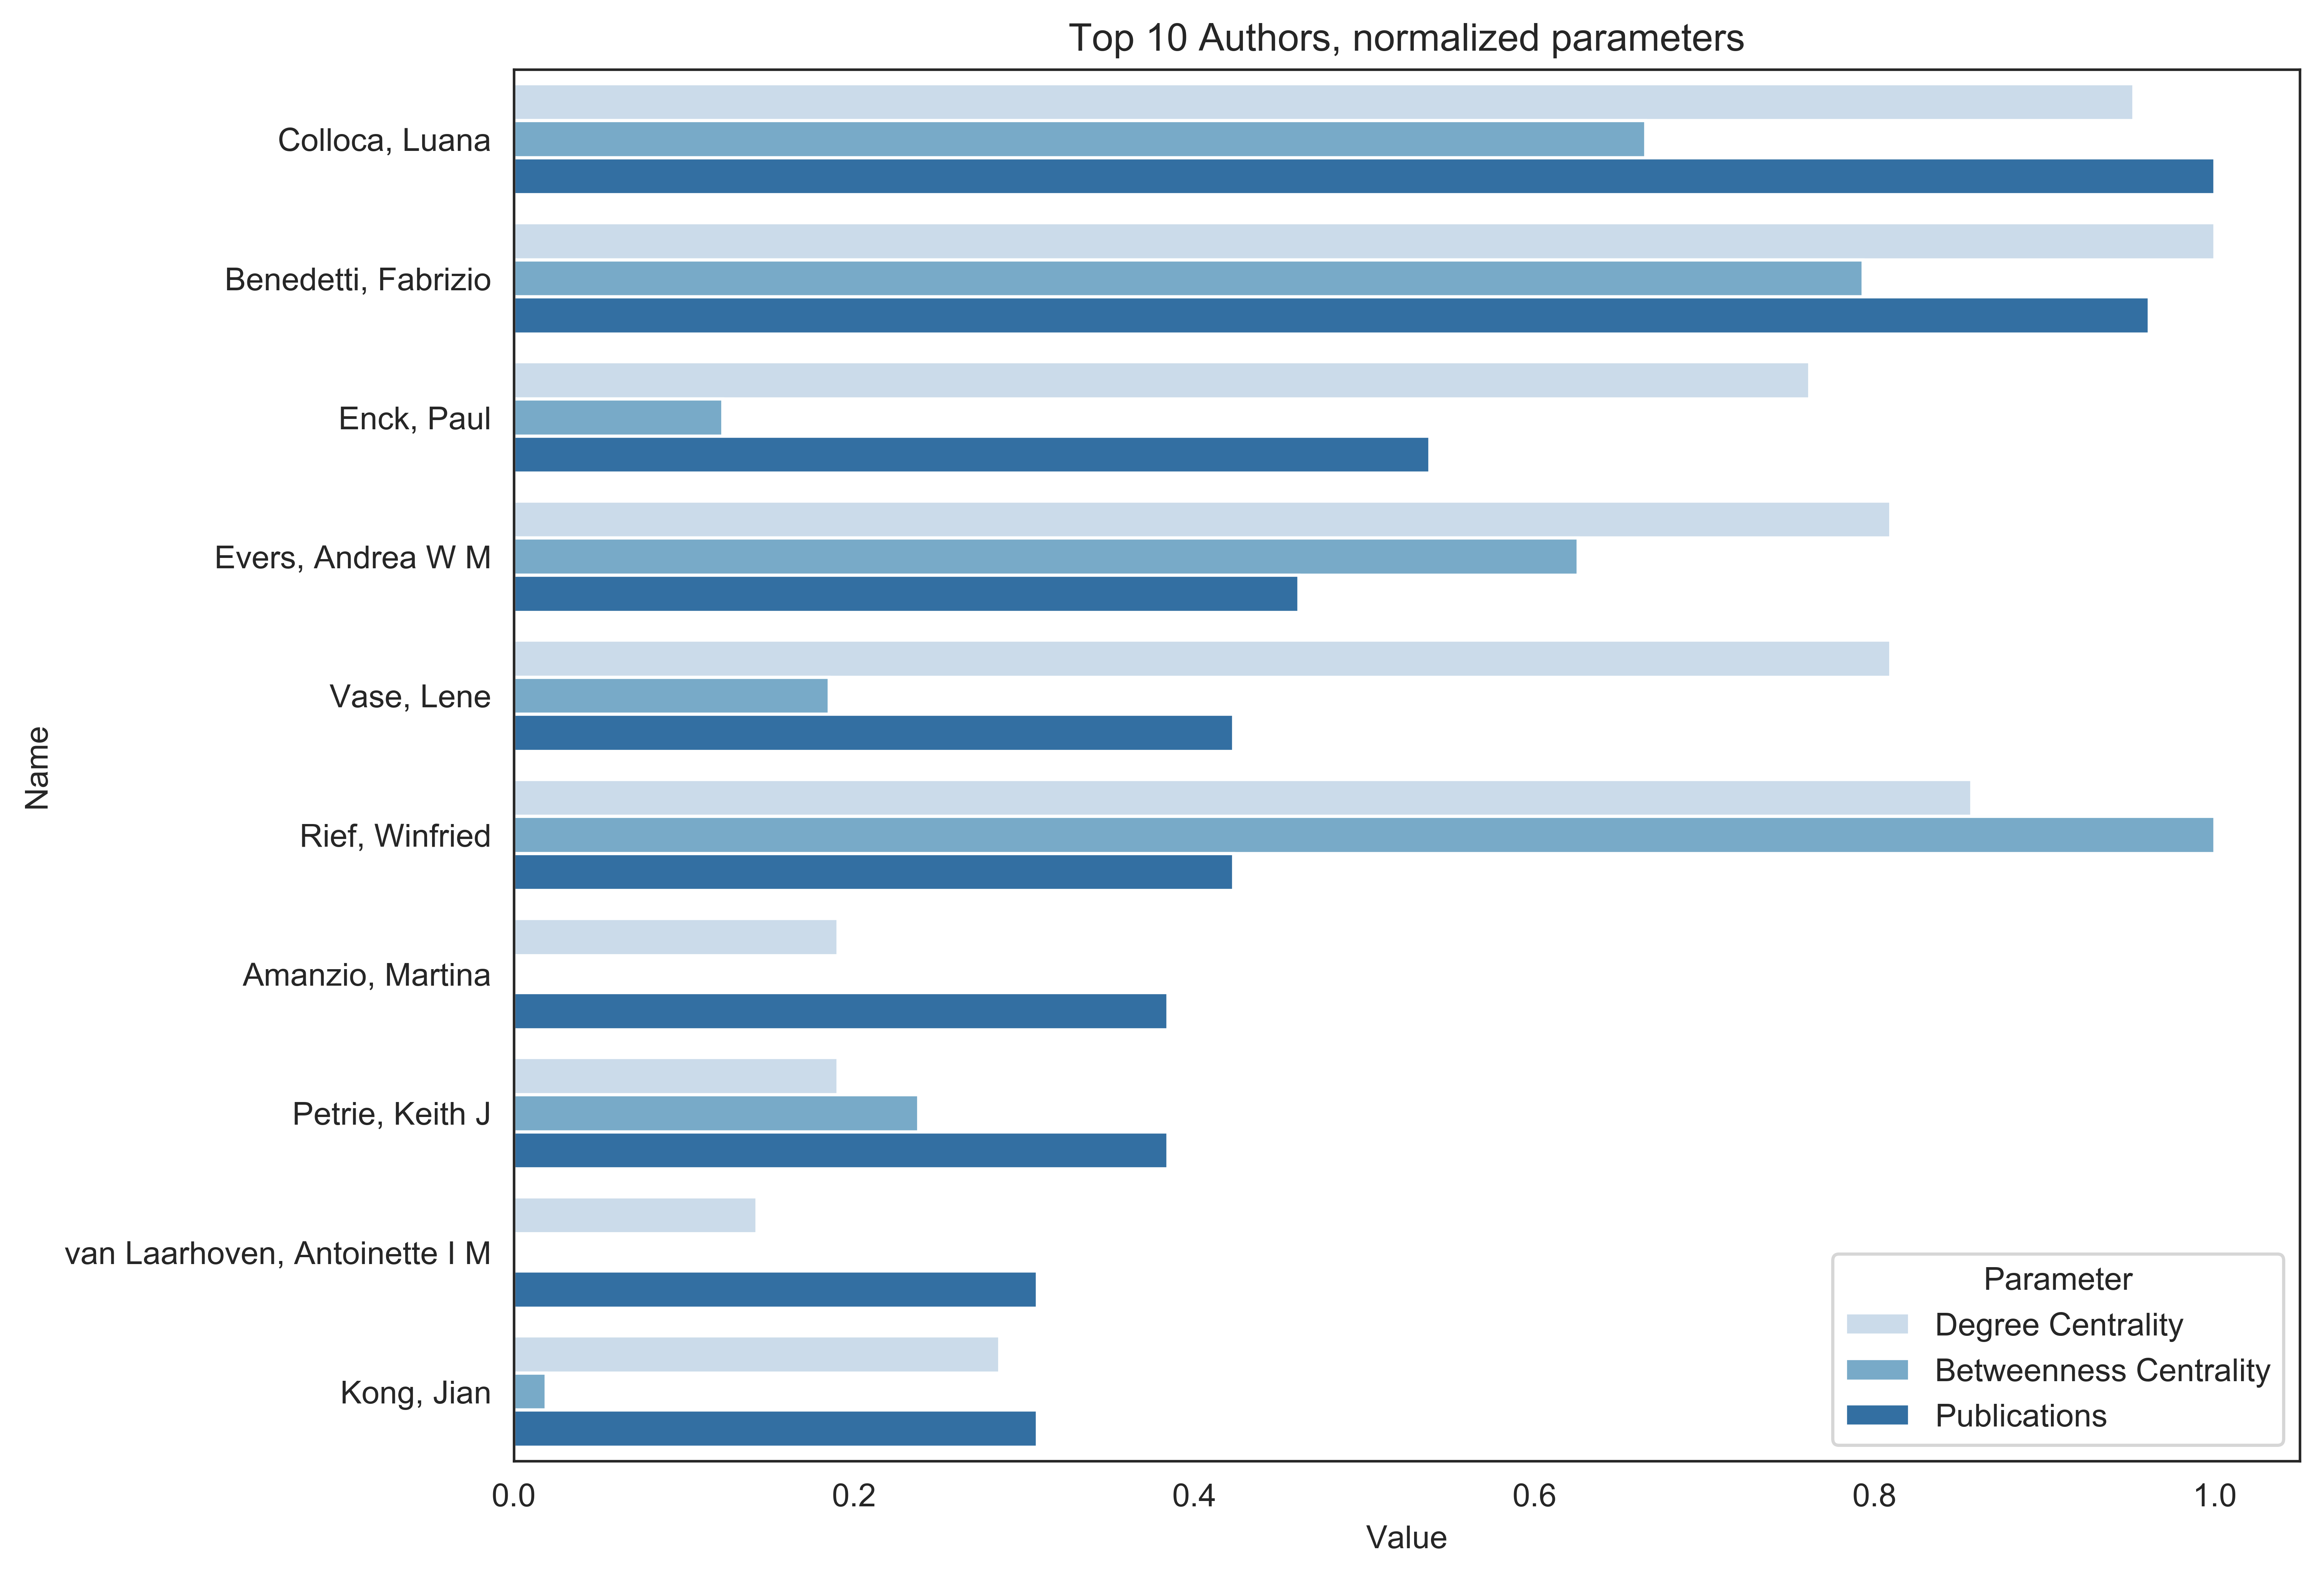

In [6]:
## Network analysis
deg = nx.degree_centrality(G_50)
bet = nx.betweenness_centrality(G_50)

top_df = pd.DataFrame.from_dict(
    [deg, bet, dict(Counter(authors_flat).most_common(50))]
).T
top_df.columns = [
    "Degree Centrality",
    "Betweenness Centrality",
    "Publications",
]

for col in top_df.columns:
    top_df[col] = top_df[col] / max(top_df[col])

top_df = top_df.sort_values("Publications", ascending=False)[:10]
top_df = pd.DataFrame(top_df.stack())
top_df = top_df.reset_index()
top_df.columns = ["Name", "Parameter", "Value"]


fig, ax = plt.subplots(figsize=(10, 8), dpi=600)

sns.barplot(x="Value", y="Name", data=top_df, hue="Parameter", palette="Blues")

plt.title("Top 10 Authors, normalized parameters")
plt.show()